In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from IPython.display import clear_output
import time
import seaborn as sns

# Unconditional Diffusion Model

## Sample data generation

In [3]:
def sample_data():
    n_samples = 500
    seed = 30

    all_points, labels = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed)
    # all_points,labels = datasets.make_moons(n_samples=n_samples, shuffle=True, noise=0.05, random_state=seed)
    
    
    all_points = torch.from_numpy(all_points).float()

    # Normalize (standardize): zero mean, unit std
    mean = torch.mean(all_points, dim=0)
    std = torch.std(all_points, dim=0)
    normalized_points = (all_points - mean) / std

    return normalized_points

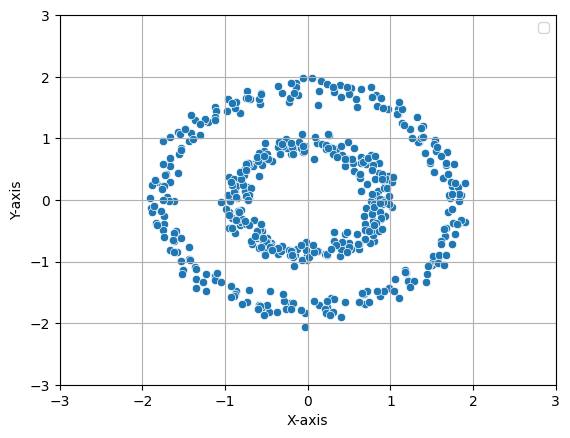

In [4]:
x0 = sample_data()

sns.scatterplot(x=x0[:, 0], y=x0[:, 1])
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.legend()
plt.grid(True)
clear_output(wait=True)
plt.show()

## Scheduler

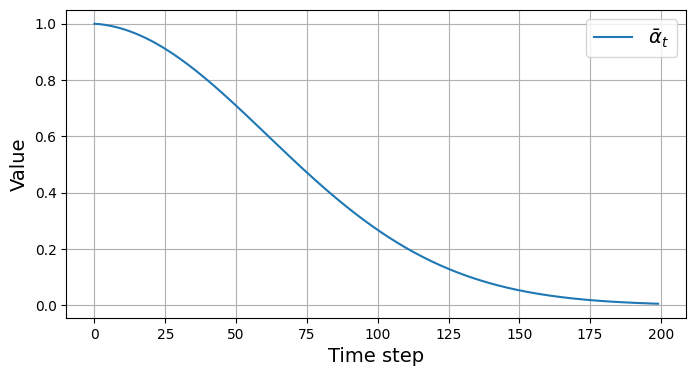

In [5]:
T = 200
scale = 1000//T

betas = torch.linspace(1e-4*scale,0.01*scale,T)
alphas = 1-betas
alpha_bars = torch.cumprod(alphas,dim=0)

# make this plot better labelled with latex text
plt.figure(figsize=(8, 4))
# plt.title(r'$\beta_t$, $\alpha_t$, and $\bar{\alpha}_t$ over time', fontsize=16)
# plt.plot(betas, label=r'$\beta_t$')
# plt.plot(alphas, label=r'$\alpha_t$')
plt.plot(alpha_bars, label=r'$\bar{\alpha}_t$')
plt.xlabel('Time step', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)      
plt.show()

## Forward diffusion

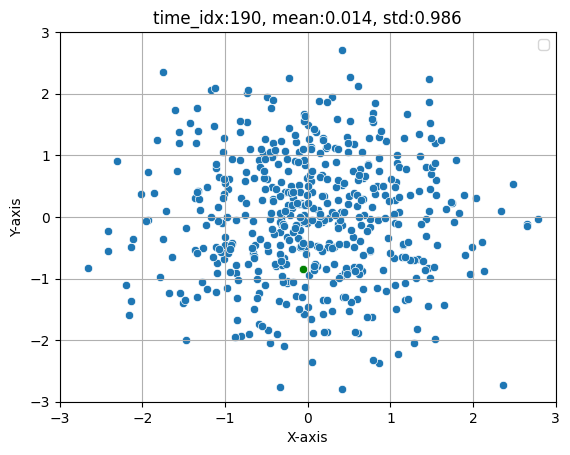

In [6]:
import seaborn as sns 

x0 = sample_data()

true_noises = []

for idx,alpha_bar in enumerate(alpha_bars[::10]):

    noise = torch.randn_like(x0)
    true_noises.append(noise)
    x_t1 = torch.sqrt(alpha_bar)*x0 + torch.sqrt(1-alpha_bar) * noise
    # The sqrt is used to make the resulted distribution gaussian with std =1 
    
    sns.scatterplot(x=x_t1[:, 0], y=x_t1[:, 1])
    sns.scatterplot(x=[x_t1[0, 0].item()], y=[x_t1[0, 1].item()], color='green')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title(f'time_idx:{idx*10}, mean:{torch.mean(x_t1):.3f}, std:{torch.std(x_t1):.3f}')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.legend()
    plt.grid(True)
    clear_output(wait=True)
    plt.show()
    time.sleep(0.1)

## Train model for Denoising Diffusion Model

In [7]:
# Define the model

class Model(nn.Module):
    def __init__(self,input_dim = 2,hidden_dim=128) -> None:
            super().__init__()
    


            self.layer_norm1 = torch.nn.LayerNorm(input_dim)
            self.layer_norm2 = torch.nn.LayerNorm(hidden_dim)
            self.layer_norm3 = torch.nn.LayerNorm(hidden_dim)
            self.output_norm = torch.nn.LayerNorm(hidden_dim)

            self.activation_fn = torch.nn.LeakyReLU(negative_slope=0.02, inplace=True)

            self.fc1 = nn.Linear(input_dim,hidden_dim)
            self.fc2 = nn.Linear(hidden_dim,hidden_dim)
            self.fc3 = nn.Linear(hidden_dim,hidden_dim)
            self.skip_fc = nn.Linear(input_dim,hidden_dim)

            self.output_fc = torch.nn.Linear(hidden_dim, input_dim)

         
            self.time_embedding_layer = nn.Sequential(
            nn.Linear(1,hidden_dim),
            self.activation_fn
            )
                                                      
            
    def forward(self,x0,t):
        time_embd = self.time_embedding_layer(t.float())

        xx = self.activation_fn(self.fc1(self.layer_norm1(x0)))
        xx = xx +time_embd + self.skip_fc(x0)
        xx = self.activation_fn(self.fc2(self.layer_norm2(xx)))
        xx = xx +time_embd + self.skip_fc(x0)
        xx = self.activation_fn(self.fc3(self.layer_norm3(xx)))
        xx = xx + time_embd + self.skip_fc(x0)
        xx = self.output_fc(self.output_norm(xx))
        
        return xx


In [8]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)

## Train the model using forward diffusion

  0%|          | 0/50000 [00:00<?, ?it/s]

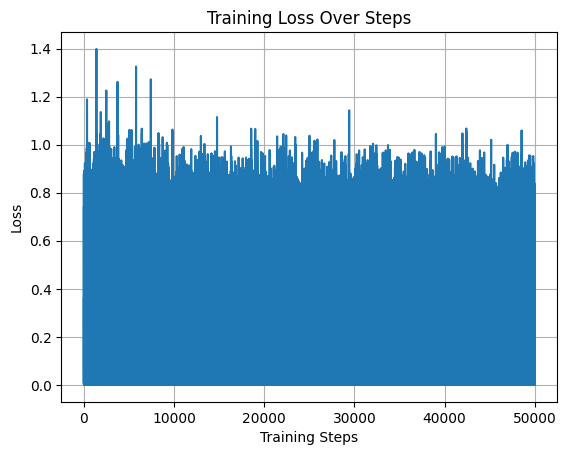

In [14]:
from tqdm.auto import tqdm

train_steps=50000
T = 200
scale = 1000//T
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

betas = torch.linspace(1e-4*scale,0.02*scale,T).to(device)
alphas = 1-betas
alpha_bars = torch.cumprod(alphas,dim=0).to(device)

x0 = sample_data()
x0=x0.to(device)


loss_list=[]
for _ in tqdm(range(train_steps)):
    
    
    noise = torch.randn_like(x0).to(device)
    
    t = torch.randint(low=1, high=T, size=(1,)).to(device)
    x_t1 = torch.sqrt(alpha_bars[t])*x0 + torch.sqrt(1-alpha_bars[t]) * noise
    
    noise_pred = model(x_t1.to(device),t)
    
    loss = criterion(noise_pred,noise)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    loss_list.append(loss.item())
    
    # break
plt.plot(loss_list)
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.title('Training Loss Over Steps')
plt.grid(True)
plt.show()

## Reverse diffusion Process DDPM

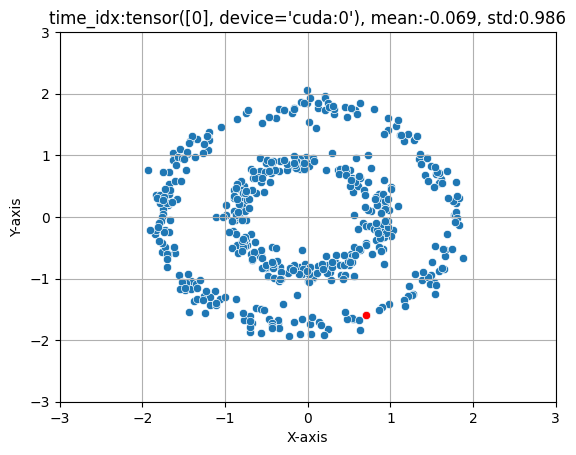

In [15]:
import imageio.v2 as imageio


x_t = torch.randn_like(x0).to(device)

for t in reversed(range(T)[::1]):
    
    t = torch.tensor(t).unsqueeze(0).to(device)
    
    alpha_t = alphas[t].to(device)
    alpha_bar_t = alpha_bars[t].to(device)
    beta_t = betas[t].to(device)
    
    with torch.inference_mode():
        noise_pred = model(x_t,t)
    # Compute the mean mu_theta as per DDPM formula
    coef1 = 1 / torch.sqrt(alpha_t)
    coef2 = beta_t / torch.sqrt(1 - alpha_bar_t)
    mu_theta = coef1 * (x_t - coef2 * noise_pred)
    
    if t > 0:
        # Sample noise for the next step
        noise = torch.randn_like(x_t).to(device)
        sigma_t = torch.sqrt(beta_t).to(device)  # or learned covariance
        x_t = mu_theta + sigma_t * noise
    else:
        # At t=0, no noise added
        x_t = mu_theta
        
    if t%5==0 :
        sns.scatterplot(x=x_t[:, 0].cpu(), y=x_t[:, 1].cpu(), )#hue=label.squeeze().cpu()
        sns.scatterplot(x=[x_t[10, 0].item()], y=[x_t[10, 1].item()], color='red')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title(f'time_idx:{t}, mean:{torch.mean(x_t):.3f}, std:{torch.std(x_t):.3f}')
        plt.xlim(-3,3)
        plt.ylim(-3,3)
        # plt.legend()
        plt.grid(True)
        clear_output(wait=True)
        plt.show()


# Conditional Diffusion


## Sample data generation with labels

In [44]:
def sample_data():
    n_samples = 500
    seed = 30

    # all_points, labels = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05, random_state=seed)
    # all_points,labels = datasets.make_moons(n_samples=n_samples, shuffle=True, noise=0.05, random_state=seed)
    
    all_points, labels = datasets.make_blobs(
        n_samples=n_samples,
        centers=4,           # <-- 4 blobs
        cluster_std=0.6,     # spread of blobs (tweakable)
        random_state=seed
    )
    
    
    all_points = torch.from_numpy(all_points).float()

    # Normalize (standardize): zero mean, unit std
    mean = torch.mean(all_points, dim=0)
    std = torch.std(all_points, dim=0)
    normalized_points = (all_points - mean) / std

    return normalized_points,torch.from_numpy(labels).float()

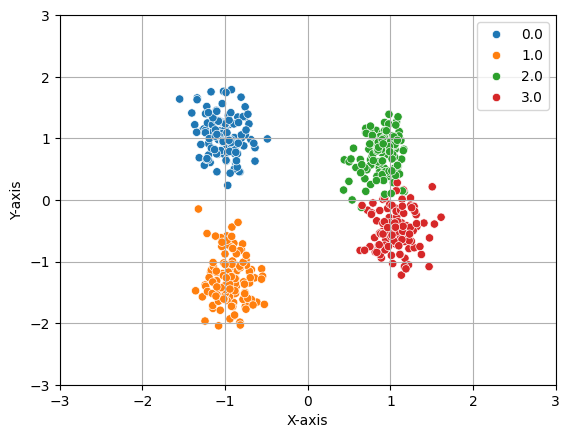

In [45]:
x0,label = sample_data()

sns.scatterplot(x=x0[:, 0], y=x0[:, 1],hue=label,palette=sns.color_palette())
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.xlim(-3,3)
plt.ylim(-3,3)
plt.legend()
plt.grid(True)
clear_output(wait=True)
plt.show()

## Scheduler

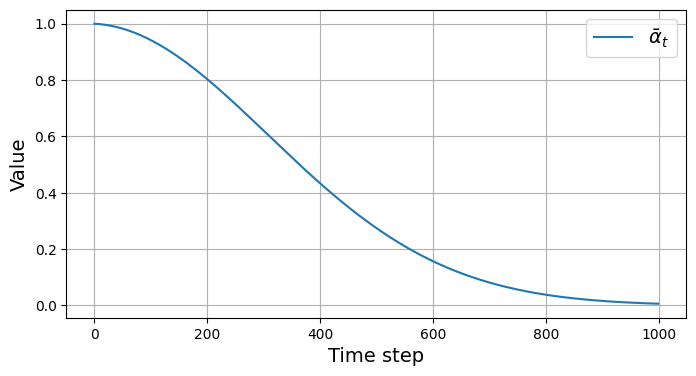

In [46]:
T = 1000
scale = 1000//T

betas = torch.linspace(1e-4*scale,0.01*scale,T)
alphas = 1-betas
alpha_bars = torch.cumprod(alphas,dim=0)

# make this plot better labelled with latex text
plt.figure(figsize=(8, 4))
plt.plot(alpha_bars, label=r'$\bar{\alpha}_t$')
plt.xlabel('Time step', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=14)
plt.grid(True)      
plt.show()

## Forward diffusion

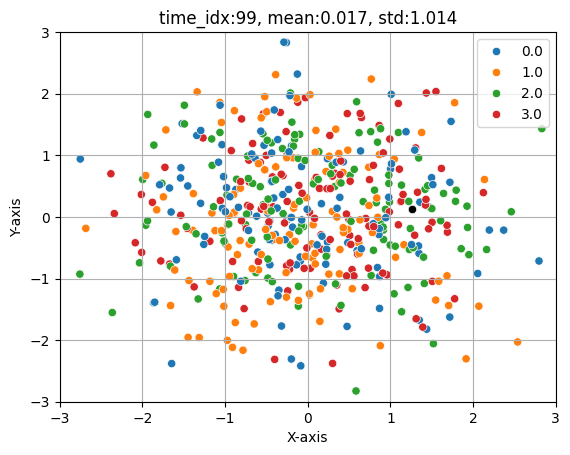

In [47]:
import seaborn as sns 

x0,label = sample_data()

true_noises = []

for idx,alpha_bar in enumerate(alpha_bars[::10]):

    noise = torch.randn_like(x0)
    true_noises.append(noise)
    x_t1 = torch.sqrt(alpha_bar)*x0 + torch.sqrt(1-alpha_bar) * noise
    # The sqrt is used to make the resulted distribution gaussian with std =1 
    
    sns.scatterplot(x=x_t1[:, 0], y=x_t1[:, 1], hue=label, palette=sns.color_palette())
    sns.scatterplot(x=[x_t1[0, 0].item()], y=[x_t1[0, 1].item()], color='black')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title(f'time_idx:{idx}, mean:{torch.mean(x_t1):.3f}, std:{torch.std(x_t1):.3f}')
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.legend()
    plt.grid(True)
    clear_output(wait=True)
    plt.show()
    time.sleep(0.1)

## Train model for Denoising Diffusion Model

In [48]:
# Define the model

class Model(nn.Module):
    def __init__(self,input_dim = 2,hidden_dim=128) -> None:
            super().__init__()
    


            self.layer_norm1 = torch.nn.LayerNorm(input_dim)
            self.layer_norm2 = torch.nn.LayerNorm(hidden_dim)
            self.layer_norm3 = torch.nn.LayerNorm(hidden_dim)
            self.output_norm = torch.nn.LayerNorm(hidden_dim)

            self.activation_fn = torch.nn.LeakyReLU(negative_slope=0.02, inplace=True)

            self.fc1 = nn.Linear(input_dim,hidden_dim)
            self.fc2 = nn.Linear(hidden_dim,hidden_dim)
            self.fc3 = nn.Linear(hidden_dim,hidden_dim)
            self.skip_fc = nn.Linear(input_dim,hidden_dim)

            self.output_fc = torch.nn.Linear(hidden_dim, input_dim)

         
            self.time_embedding_layer = nn.Sequential(
            nn.Linear(1,hidden_dim),
            self.activation_fn
            )
            
            # Only new line is added
            self.class_embedding_layer = nn.Sequential(
            nn.Linear(1,hidden_dim),
            self.activation_fn
            )
                                                      
            
    def forward(self,x0,t,c):
        time_embd = self.time_embedding_layer(t.float())
        class_embd = self.class_embedding_layer(c.float())

        xx = self.activation_fn(self.fc1(self.layer_norm1(x0)))
        xx = xx +time_embd + class_embd + self.skip_fc(x0) # class embedding added
        xx = self.activation_fn(self.fc2(self.layer_norm2(xx)))
        xx = xx +time_embd + class_embd + self.skip_fc(x0) # class embedding added
        xx = self.activation_fn(self.fc3(self.layer_norm3(xx)))
        xx = xx + time_embd + class_embd + self.skip_fc(x0) # class embedding added
        xx = self.output_fc(self.output_norm(xx))
        
        return xx


In [49]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model().to(device)

## Train the model using forward diffusion

  0%|          | 0/50000 [00:00<?, ?it/s]

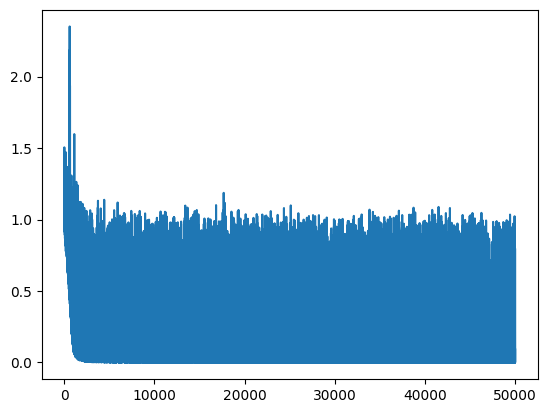

In [50]:
from tqdm.auto import tqdm

train_steps=50000
T = 200
scale = 1000//T
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

betas = torch.linspace(1e-4*scale,0.02*scale,T).to(device)
alphas = 1-betas
alpha_bars = torch.cumprod(alphas,dim=0).to(device)

x0,label = sample_data()
x0=x0.to(device)
label = label.unsqueeze(1).to(device)


loss_list=[]
for _ in tqdm(range(train_steps)):
    
    
    noise = torch.randn_like(x0).to(device)
    
    t = torch.randint(low=1, high=T, size=(1,)).to(device)
    x_t1 = torch.sqrt(alpha_bars[t])*x0 + torch.sqrt(1-alpha_bars[t]) * noise
    
    noise_pred = model(x_t1.to(device),t,label)
    
    loss = criterion(noise_pred,noise)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    loss_list.append(loss.item())
    
    # break
plt.plot(loss_list)
plt.show()

## Reverse diffusion Process DDPM

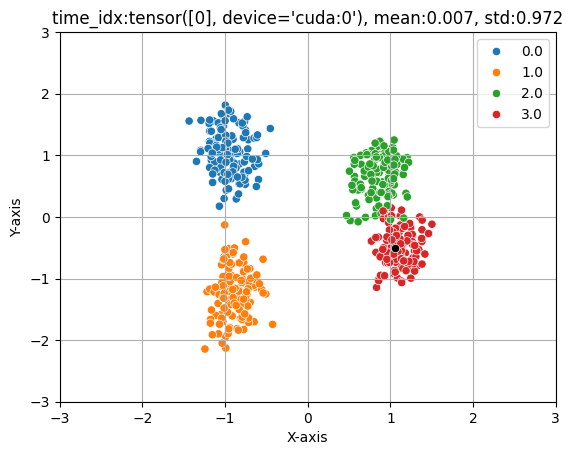

In [53]:

x_t = torch.randn_like(x0).to(device)

for t in reversed(range(T)[::1]):
    
    t = torch.tensor(t).unsqueeze(0).to(device)
    
    alpha_t = alphas[t].to(device)
    alpha_bar_t = alpha_bars[t].to(device)
    beta_t = betas[t].to(device)
    
    with torch.inference_mode():
        noise_pred = model(x_t,t,label)
    # Compute the mean mu_theta as per DDPM formula
    coef1 = 1 / torch.sqrt(alpha_t)
    coef2 = beta_t / torch.sqrt(1 - alpha_bar_t)
    mu_theta = coef1 * (x_t - coef2 * noise_pred)
    
    if t > 0:
        # Sample noise for the next step
        noise = torch.randn_like(x_t).to(device)
        sigma_t = torch.sqrt(beta_t).to(device)  # or learned covariance
        x_t = mu_theta + sigma_t * noise
    else:
        # At t=0, no noise added
        x_t = mu_theta
        
    if t%5==0 :
        sns.scatterplot(x=x_t[:, 0].cpu(), y=x_t[:, 1].cpu(),hue=label.squeeze().cpu(),palette=sns.color_palette())
        sns.scatterplot(x=[x_t[10, 0].item()], y=[x_t[10, 1].item()], color='black')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title(f'time_idx:{t}, mean:{torch.mean(x_t):.3f}, std:{torch.std(x_t):.3f}')
        plt.xlim(-3,3)
        plt.ylim(-3,3)
        # plt.legend()
        plt.grid(True)
        clear_output(wait=True)
        plt.show()



# DDIM

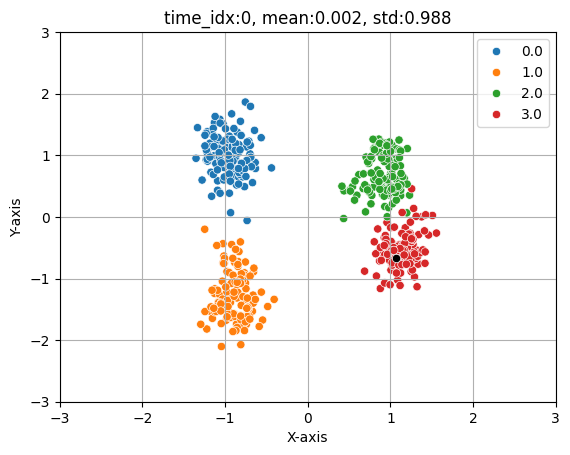

In [55]:
x_t = torch.randn_like(x0).to(device)

eta=0.1

for t in reversed(range(T)[::1]):
    
    t_cur = torch.tensor([t]).to(device)
    t_prev = torch.tensor([t - 1]).to(device) if t-1 >=0 else torch.tensor([-1]).to(device)

    alpha_bar_t = alpha_bars[t_cur].to(device)
    alpha_bar_prev = alpha_bars[t_prev].to(device)
    
    with torch.inference_mode():
        eps_theta = model(x_t, t_cur, label)

    # Deterministic DDIM update (eta = 0)
    x0_pred = (x_t - torch.sqrt(1 - alpha_bar_t) * eps_theta) / torch.sqrt(alpha_bar_t)

    x_t = (
        torch.sqrt(alpha_bar_prev) * x0_pred +
        torch.sqrt(1 - alpha_bar_prev) * eps_theta
    ) if t_prev >= 0 else x0_pred
    
    # if eta is not 0, add noise here (omitted for simplicity)
    
    # sigma_t = (eta
    # * torch.sqrt(
    #     (1 - alpha_bar_prev) / (1 - alpha_bar_t)
    #     * (1 - alpha_bar_t / alpha_bar_prev)
    # ))

    # z = torch.randn_like(x_t)

    # x_t = (
    # torch.sqrt(alpha_bar_prev) * x0_pred
    # + torch.sqrt(1 - alpha_bar_prev - sigma_t**2) * eps_theta
    # + sigma_t * z
    # ) if t_prev >= 0 else x0_pred



    if t % 10 == 0:
        sns.scatterplot(x=x_t[:, 0].cpu(), y=x_t[:, 1].cpu(),hue=label.squeeze().cpu(),palette=sns.color_palette())
        sns.scatterplot(x=[x_t[10, 0].item()], y=[x_t[10, 1].item()], color='black')
        plt.xlabel('X-axis')
        plt.ylabel('Y-axis')
        plt.title(f'time_idx:{t}, mean:{torch.mean(x_t):.3f}, std:{torch.std(x_t):.3f}')
        plt.xlim(-3,3)
        plt.ylim(-3,3)
        plt.legend()
        plt.grid(True)
        clear_output(wait=True)
        plt.show()
        time.sleep(0.1)
